# IFORM contour in n dimension

This tutorial illustrates the use of the ````DirectIform```` class to generate n dimensional contours. This handles projections and slices as well. 

References : 

- [Model-free environmental contours in higher dimensions](https://www.researchgate.net/profile/Ed-Mackay/publication/365459533_Model-free_environmental_contours_in_higher_dimensions/links/6376313954eb5f547cde7073/Model-free-environmental-contours-in-higher-dimensions.pdf?origin=publicationDetail&_rtd=eyJjb250ZW50SW50ZW50Ijoic2ltaWxhciJ9)

- [A New Approach for Environmental Contour and Multivariate De-Clustering](https://doi.org/10.1115/OMAE2019-95993)

- https://github.com/edmackay/Direct-IFORM


In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from Snoopy.Statistics import TEST_DATA
from Snoopy.Statistics import DirectIform
from Snoopy import PyplotTools as dplt

## Input data

In [2]:
a = loadmat( f"{TEST_DATA:}/Data_Celtic_Sea.mat", struct_as_record = False )
names = ["Hs" , "Tm" , "U10" , "dir_rel"]
df = pd.DataFrame( index = a["time"][:,0] , data = { k:a[k][:,0] for k in names  } )

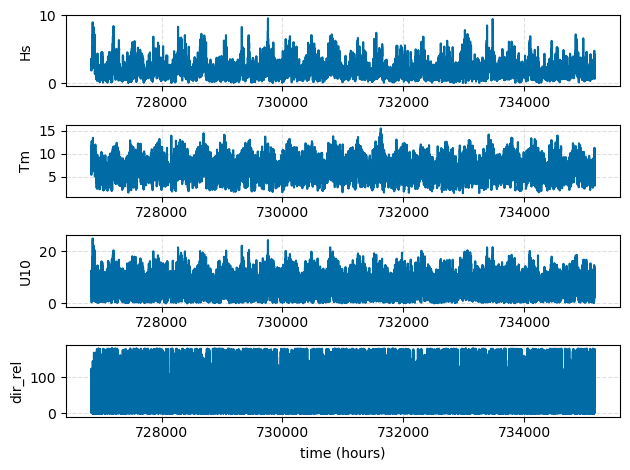

In [18]:
# Plot time traces of the variables
fig, ax = plt.subplots(nrows = 4)
for i, v in enumerate(names) : 
    df[v].iloc[:200000].plot(ax=ax[i])
    ax[i].set(ylabel = v)
ax[-1].set(xlabel = "time (hours)")
plt.tight_layout()

In [20]:
# Variable change, so that data cloud is more convex
df.loc[: , "Hs**0.5"] = df.loc[: , "Hs"]**0.5
df["HL"] = df.Hs**0.5 * np.cos( df.dir_rel*np.pi/180 )
df["HT"] = df.Hs**0.5 * np.sin( df.dir_rel*np.pi/180 )
# dplt._scatterPlot.density_pairplot( df.loc[:, ["HL" , "HT" , "Tm" , "U10"]] );

In [21]:
# Variable change dictionnary, this will be used to plot results in any desired space
transform_dict =  {  "Hs" : lambda df:df["Hs**0.5"]**2,
                     "Hs " : lambda df : (df["HL"]**2 +  df["HT"] **2), 
                     "Hs**0.5" : lambda df : (df["HL"]**2 +  df["HT"] **2)**0.5 ,
                     "Hs_L" : lambda df : (df["HL"]**2 + df["HT"]**2) * np.cos( np.arctan2(  df["HT"] ,  df["HL"] ) ) ,
                     "Hs_T" : lambda df : (df["HL"]**2 + df["HT"]**2) * np.sin( np.arctan2(  df["HT"] ,  df["HL"] ) ) ,
                     "THETA_REL" : lambda df : np.rad2deg(np.arctan2(  df["HT"] ,  df["HL"]  ))
                  }

## Fit on all projection directions

In [22]:
# The DirectIform object is created with input data, directions discretisation and parameter for the POT univariate fit.
diform_4d = DirectIform( df.loc[: , ["HL" , "HT", "Tm" , "U10"  ] ],  # Time traces to analyse
                         npoints = 11,                                # Discretisation for direction vector, per variable.
                         window_int= 48,                              # Size of the de-clustering windows
                         duration = len(df) / (24*365), threshold_q = 0.9, # Duration of the time traces
                         pot_kwargs = { "shape_bounds" : (None, -1e-12) } )  # Optional argument passed to the POT_GPD analysis (here, we imposed that the GPD si bounded)

# Perform the analysis for all search directions.
diform_4d.fit_projections()

Fitting projections: 100%|██████████| 2720/2720 [00:48<00:00, 56.56it/s]


The result of this is fit parameters and return value for all projection directions, stored in a dataframe :

In [20]:
diform_4d.results_df

HL_a      HT_a      Tm_a     U10_a  THRESHOLD     SCALE     SHAPE  \
0     0.000000  0.000000  0.000000  1.000000   2.490882  0.570053 -0.136997   
1     0.000000  0.000000  0.110432  0.993884   2.545288  0.594480 -0.124147   
2     0.000000  0.000000  0.242536  0.970143   2.554317  0.655910 -0.136850   
3     0.000000  0.000000  0.393919  0.919145   2.538172  0.679223 -0.127954   
4     0.000000  0.000000  0.554700  0.832050   2.446744  0.714128 -0.139254   
...        ...       ...       ...       ...        ...       ...       ...   
2715 -0.833333 -0.500000 -0.166667 -0.166667   2.773408  0.166066 -0.321124   
2716 -0.925820 -0.154303 -0.154303 -0.308607   2.685832  0.171996 -0.173384   
2717 -0.925820 -0.154303 -0.308607 -0.154303   2.459051  0.177984 -0.456792   
2718 -0.925820 -0.308607 -0.154303 -0.154303   2.722675  0.181118 -0.279794   
2719 -0.970725 -0.138675 -0.138675 -0.138675   2.588264  0.205788 -0.291336   

            NNLF  KS-PVALUE  
0     126.738751   0.706933  
1     149.066278   0.788205  
2     183.203503   0.909675  
3     199.456489   0.483505  
4     210.664237   0.870159  
...          ...        ...  
2715 -472.269878   0.649036  
2716 -380.930317   0.556642  
2717 -479.034747   0.278030  
2718 -400.315363   0.946461  
2719 -355.880627   0.732100  

[2720 rows x 9 columns]

## Extract contours and plot projections

The 4D contour can be retrieved with ````extract_contour```` 

In [21]:
diform_4d.extract_contour( rp = 50. )

Evaluate RP at each projection: 100%|██████████| 2720/2720 [00:00<00:00, 6538.44it/s]


HL        HT         Tm        U10
0    -0.452823  2.242430  12.491020  13.602860
1     1.245197  2.222560  12.919597  15.311315
2     1.389207  2.162663  12.951439  15.885061
3    -0.151463  2.353588  13.362573  10.697719
4    -0.387946  2.304032  13.374291   7.667645
...        ...       ...        ...        ...
9400  3.041430  0.179926  11.946435  21.170213
9401  3.020078  0.114171  11.945432  20.488022
9402  3.018114  0.113173  11.950206  20.433276
9403  2.984367  0.132324  12.148095  19.681805
9404  2.982404  0.131326  12.152870  19.627059

[9405 rows x 4 columns]

For visualisation, we can project this contour in lower dimensions:

In [24]:
diform_4d.plot_projection_3d( variables = [ "Hs**0.5" , "U10" , "Tm"] ,  # Variable in which the projection is performed
                              final_variables=["Hs", "U10", "Tm"] ,      # Variable in which the results is plotted.
                              rp = 25.0,                        # Return period
                              transform_dict = transform_dict,  # How to transform ````variables```` to ````final_variables````
                              backend = "plotly",  # plotting backend. 
                              )

In [34]:
rp_dict = { 1.0 : "darkblue" ,
            5.0 : "darkorange",
            50.0 : "green"}

Evaluate RP at each projection: 100%|██████████| 2720/2720 [00:00<00:00, 6956.40it/s]


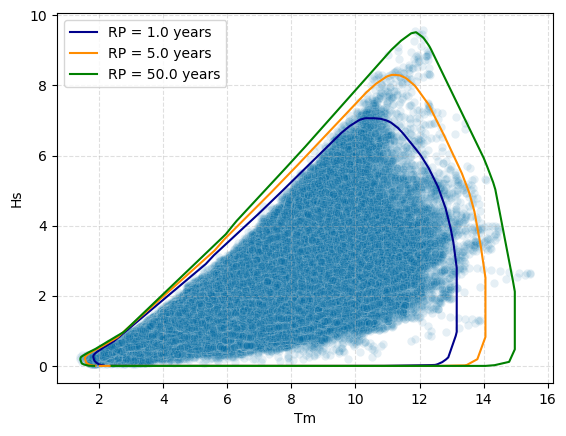

In [25]:
fig, ax = plt.subplots()
for rp, c in rp_dict.items() :
    diform_4d.plot_projection_2d( variables = ["Tm", "Hs**0.5"], final_variables = ["Tm", "Hs"] , rp = rp ,
                                  transform_dict=transform_dict, ax=ax, label = f"RP = {rp:} years", color = c)
sns.scatterplot(ax=ax, data = df, x = "Tm" , y = "Hs" , marker = "o", alpha = 0.1);
ax.legend();

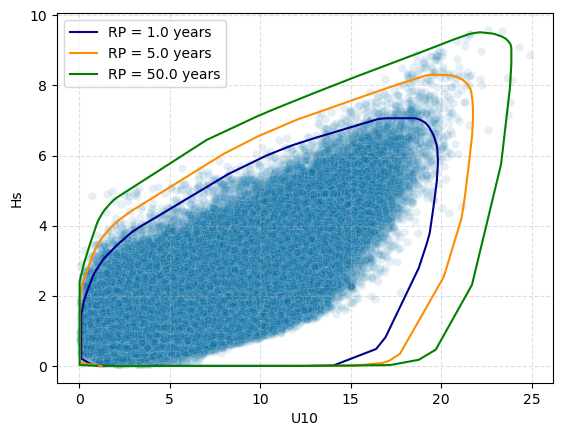

In [26]:
fig, ax = plt.subplots()
for rp, c in rp_dict.items() :
    diform_4d.plot_projection_2d( variables = ["U10", "Hs**0.5"], final_variables = ["U10", "Hs"] , rp = rp, ax=ax,
                                 transform_dict = transform_dict, label = f"RP = {rp:} years" , color = c) 
sns.scatterplot(ax=ax, data = df, x = "U10" , y = "Hs", marker = "o", alpha = 0.1 )
ax.legend();

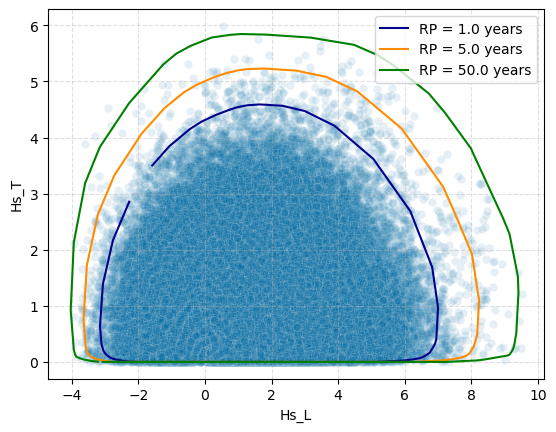

In [27]:
fig, ax = plt.subplots()
for rp, c in rp_dict.items() :
    diform_4d.plot_projection_2d( variables = ["HL", "HT"], final_variables = ["Hs_L", "Hs_T"] , rp = rp, ax=ax,
                                 transform_dict = transform_dict, label = f"RP = {rp:} years" , color =c) 
diform_4d.plot_data_2d( variables = ["Hs_L", "Hs_T"], transform_dict = transform_dict, ax=ax, alpha = 0.1)
ax.legend(loc = "upper right");

Slices can also be retrieved : 

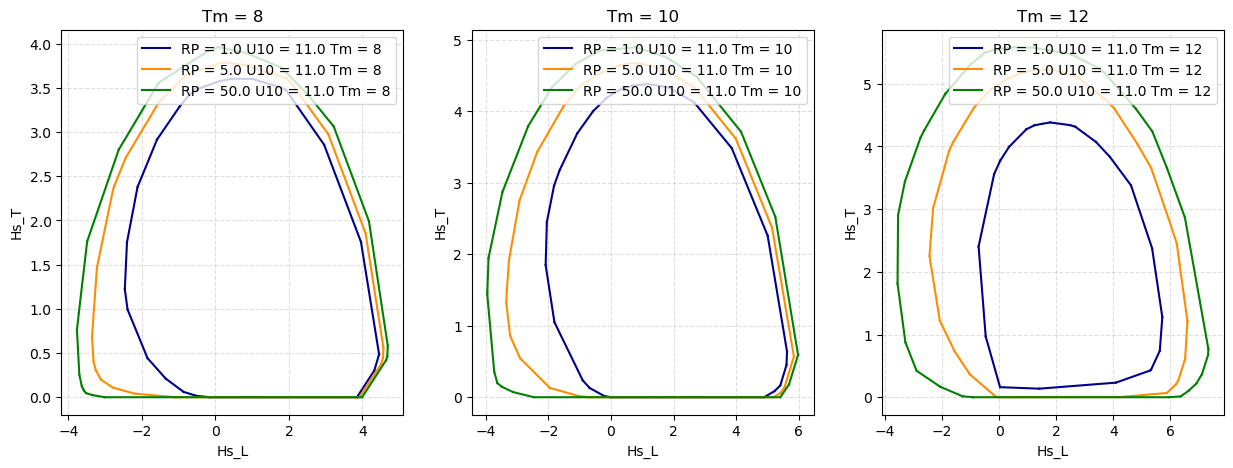

In [28]:
U10_cut = 11.0
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
for i, tm in enumerate([8, 10, 12]):
    for rp, c in rp_dict.items() :
        diform_4d.plot_slice_2d( slice_dims=["U10", "Tm"], slice_values=[U10_cut, tm], final_variables = ["Hs_L", "Hs_T"],   rp = rp, color = c, ax=ax[i], transform_dict = transform_dict)
    ax[i].legend(loc = "upper right");
    ax[i].set(title = f"Tm = {tm:}")

## Diagnostic plots

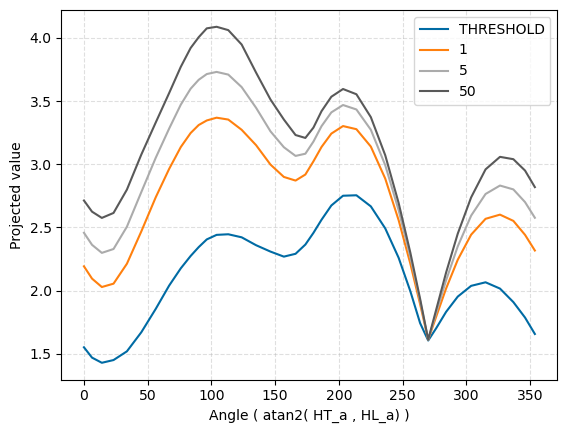

In [29]:
diform_4d.plot_angle_parameters( plane = ["HL_a"  , "HT_a" ], values = ["THRESHOLD" , 1.0 , 5.0 , 50.] );

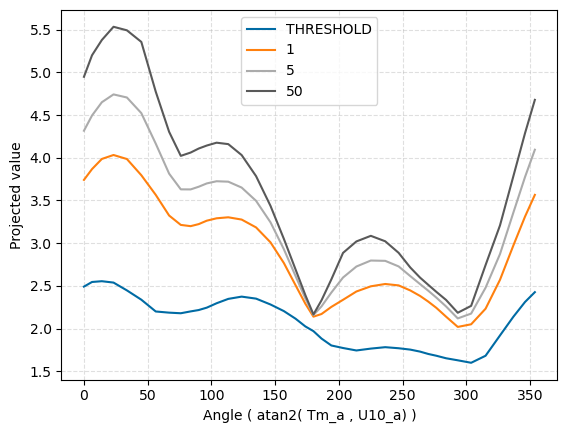

In [30]:
diform_4d.plot_angle_parameters( plane = ["U10_a"  , "Tm_a" ], values = ["THRESHOLD" , 1.0 , 5.0 , 50.] );

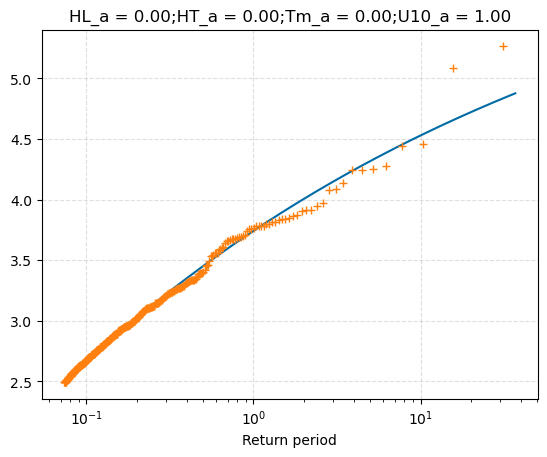

In [31]:
diform_4d.plot_univariate( i_direction = 0 );

## Additional plots

Plot the contour in the "original" dimension:

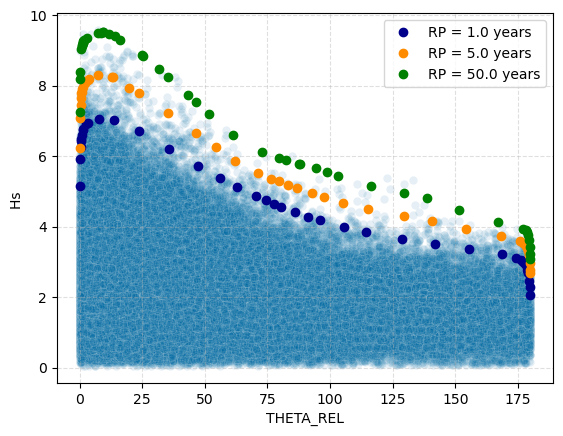

In [32]:
fig, ax = plt.subplots()
for rp, c in rp_dict.items() :
    diform_4d.plot_projection_2d( variables = ["HL", "HT"], final_variables = ["THETA_REL", "Hs "] , rp = rp, ax=ax,
                                  transform_dict = transform_dict, label = f"RP = {rp:} years", marker = "o", linestyle = "", color = c)
diform_4d.plot_data_2d( variables = ["THETA_REL", "Hs "] , transform_dict = transform_dict, ax=ax, alpha = 0.1)
ax.legend(loc = "upper right");

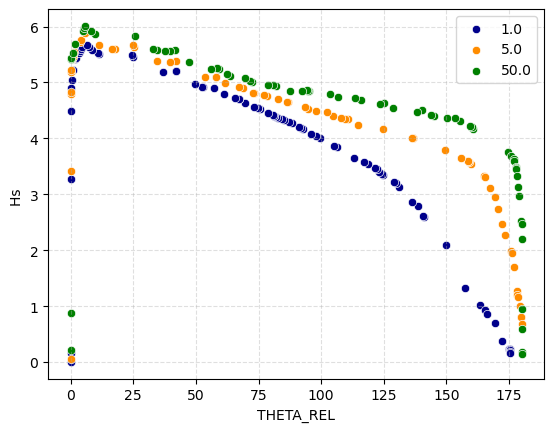

In [33]:
fig, ax= plt.subplots()
for rp, c in rp_dict.items() :
    slice_df = diform_4d.sliced_contour( slice_dims=["U10", "Tm"], slice_values=[11.0, 10.0], final_variables = ["THETA_REL", "Hs "],
                                         rp = rp, transform_dict = transform_dict )
    sns.scatterplot(data = slice_df , x = "THETA_REL" , y = "Hs " , color = c, ax=ax, label = f"{rp:}" )
ax.legend();